<a href="https://colab.research.google.com/github/damiangarmol/TFG_codigo/blob/main/redes_neuronales_tfg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Red Neuronal - Índices Bursátiles Mundiales

In [ ]:
# Cargar los datos desde un archivo Excel
data = pd.read_excel('/content/global_index_excel.xlsx', parse_dates=['Date'])

# Seleccionar las columnas con los valores de las empresas
company_columns = ['SP500', 'NASDAQ100', 'MOEX_RUSSIA', 'PFTS_UKRAINE', 'CSI_CHINA']
print(data)

           Date    SP500  NASDAQ100  MOEX_RUSSIA  PFTS_UKRAINE  CSI_CHINA
0    2015-01-06  2002.61    4110.83      1480.73        393.57    6172.39
1    2015-01-08  2062.14    4240.55      1547.39        393.43    6164.11
2    2015-01-09  2044.81    4213.28      1515.37        394.38    6128.01
3    2015-01-12  2028.26    4169.97      1513.22        400.78    6062.28
4    2015-01-13  2023.03    4166.20      1533.09        408.40    6167.12
...         ...      ...        ...          ...           ...        ...
1709 2022-12-28  3783.22   10679.34      2139.77        519.20    6270.94
1710 2022-12-29  3849.28   10951.05      2147.06        519.20    6263.09
1711 2022-12-30  3839.50   10939.76      2154.12        519.20    6281.68
1712 2023-01-03  3824.14   10862.64      2172.68        519.20    6425.63
1713 2023-01-04  3828.87   10914.80      2166.96        519.20    6420.41

[1714 rows x 6 columns]


Epoch 1/100
27/27 [==============================] - 11s 328ms/step - loss: 0.0264
Epoch 2/100
27/27 [==============================] - 10s 364ms/step - loss: 0.0024
Epoch 3/100
27/27 [==============================] - 10s 376ms/step - loss: 0.0012
Epoch 4/100
27/27 [==============================] - 10s 377ms/step - loss: 0.0010
Epoch 5/100
27/27 [==============================] - 9s 347ms/step - loss: 9.6836e-04
Epoch 6/100
27/27 [==============================] - 10s 359ms/step - loss: 8.7475e-04
Epoch 7/100
27/27 [==============================] - 10s 384ms/step - loss: 8.1460e-04
Epoch 8/100
27/27 [==============================] - 10s 385ms/step - loss: 7.6121e-04
Epoch 9/100
27/27 [==============================] - 10s 372ms/step - loss: 7.5602e-04
Epoch 10/100
27/27 [==============================] - 9s 334ms/step - loss: 7.2900e-04
Epoch 11/100
27/27 [==============================] - 10s 381ms/step - loss: 6.3823e-04
Epoch 12/100
27/27 [==============================] - 10s 3

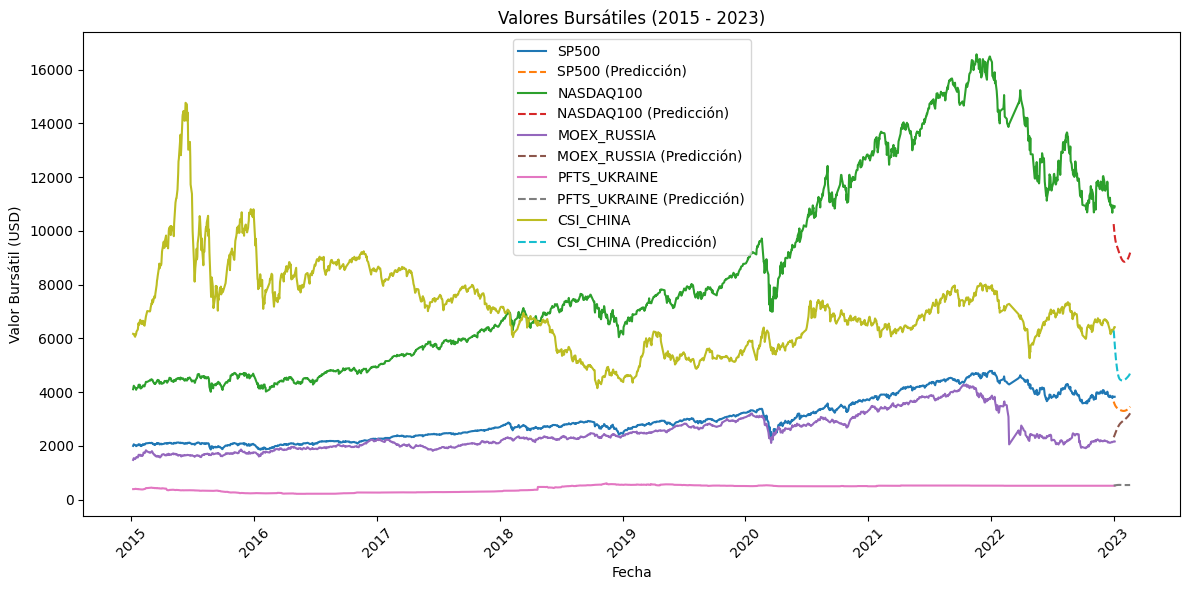

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Cargar los datos desde un archivo Excel
data = pd.read_excel('/content/global_index_excel.xlsx', parse_dates=['Date'])

# Seleccionar las columnas con los valores de las empresas
company_columns = ['SP500', 'NASDAQ100', 'MOEX_RUSSIA', 'PFTS_UKRAINE', 'CSI_CHINA']

# Obtener los valores de las empresas como una matriz 2D
values = data[company_columns].values

# Normalizar los datos
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_values = scaler.fit_transform(values)

# Dividir los datos en conjuntos de entrenamiento y prueba
train_size = int(len(scaled_values) * 0.8)
train_data, test_data = scaled_values[:train_size], scaled_values[train_size:]

# Crear conjuntos de datos de entrada y salida
def create_dataset(data, window_size):
    X, y = [], []
    for i in range(len(data) - window_size - 1):
        X.append(data[i:(i + window_size), :])
        y.append(data[i + window_size, :])
    return np.array(X), np.array(y)

window_size = 30  # Tamaño de la ventana para el conjunto de datos de entrada
X_train, y_train = create_dataset(train_data, window_size)
X_test, y_test = create_dataset(test_data, window_size)

# Crear el modelo de red neuronal
model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(500, activation='relu', input_shape=(window_size, len(company_columns))),
    tf.keras.layers.Dense(len(company_columns))
])

# Compilar el modelo
model.compile(optimizer='adam', loss='mean_squared_error')

# Entrenar el modelo
model.fit(X_train, y_train, epochs=100, batch_size=50)

# Realizar predicciones
train_predictions = model.predict(X_train)
test_predictions = model.predict(X_test)

# Invertir la normalización de los datos
train_predictions = scaler.inverse_transform(train_predictions)
y_train = scaler.inverse_transform(y_train)
test_predictions = scaler.inverse_transform(test_predictions)
y_test = scaler.inverse_transform(y_test)

# Calcular el error RMSE
train_rmse = np.sqrt(mean_squared_error(y_train, train_predictions))
test_rmse = np.sqrt(mean_squared_error(y_test, test_predictions))
print("RMSE (Entrenamiento):", train_rmse)
print("RMSE (Prueba):", test_rmse)

# Obtener la ventana de datos de prueba más reciente
last_window = scaled_values[-window_size:, :]

# Realizar predicción de los próximos 50 días
future_predictions = []
for _ in range(50):
    future_prediction = model.predict(last_window.reshape(1, window_size, len(company_columns)))
    future_predictions.append(future_prediction)
    last_window = np.append(last_window[1:, :], future_prediction, axis=0)

# Invertir la normalización de las predicciones futuras
future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1, len(company_columns)))

# Crear las fechas para los próximos 50 días a partir del 1 de enero de 2023
start_date = pd.to_datetime('2023-01-01')
date_range = pd.date_range(start=start_date, periods=50)

# Graficar los resultados
plt.figure(figsize=(12, 6))
for i, company in enumerate(company_columns):
    plt.plot(data['Date'], values[:, i], label=company)
    plt.plot(date_range, future_predictions[:, i], label=f'{company} (Predicción)', linestyle='--')

plt.xlabel('Fecha')
plt.ylabel('Valor Bursátil (USD)')
plt.title('Valores Bursátiles (2015 - 2023)')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


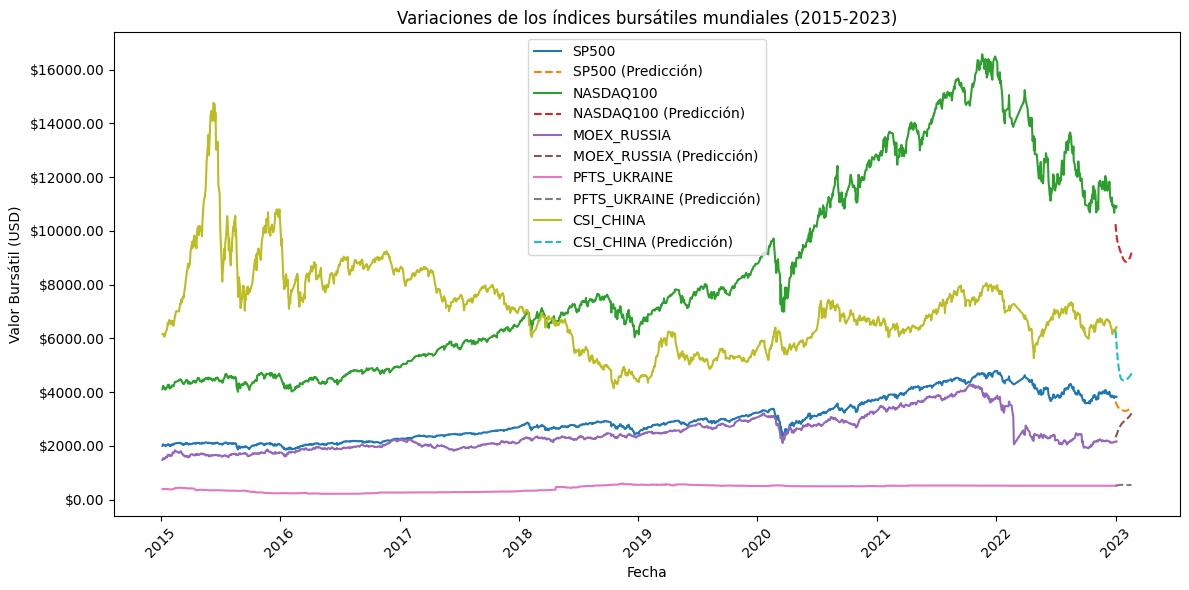

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# Graficar los resultados
plt.figure(figsize=(12, 6))
for i, company in enumerate(company_columns):
    plt.plot(data['Date'], values[:, i], label=company)
    plt.plot(date_range, future_predictions[:, i], label=f'{company} (Predicción)', linestyle='--')

# Función para formatear los valores en dólares
def dollar_format(x, pos):
    return f'${x:.2f}'

# Configurar el formateador de ejes para mostrar valores en dólares
formatter = ticker.FuncFormatter(dollar_format)
plt.gca().yaxis.set_major_formatter(formatter)

plt.xlabel('Fecha')
plt.ylabel('Valor Bursátil (USD)')
plt.title('Variaciones de los índices bursátiles mundiales (2015-2023)')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


#Red Neuronal - Industrias INVUS 500


In [ ]:
data = pd.read_excel('/content/Industry SP500 Mean.xlsx', parse_dates=['Date'])
print(data)

           Date  Utilities Industry  Real Estate Industry  Materials Industry  \
0    2015-01-02           51.013929             88.483929           66.312500   
1    2015-01-05           50.316071             88.751786           64.615833   
2    2015-01-06           50.302143             89.506429           64.208750   
3    2015-01-07           50.901071             90.783571           64.844167   
4    2015-01-08           51.265357             91.261071           66.495833   
...         ...                 ...                   ...                 ...   
2022 2023-01-13           76.370000            135.627500          141.840833   
2023 2023-01-17           76.150000            135.671429          140.597917   
2024 2023-01-18           74.306429            133.139286          138.881667   
2025 2023-01-19           73.628214            132.716071          136.945417   
2026 2023-01-20           74.267857            134.299286          140.247917   

      Information Technolog

##INVUS 500 - Todas las Industrias

Epoch 1/60
32/32 [==============================] - 7s 141ms/step - loss: 0.0200
Epoch 2/60
32/32 [==============================] - 4s 135ms/step - loss: 0.0019
Epoch 3/60
32/32 [==============================] - 6s 174ms/step - loss: 0.0011
Epoch 4/60
32/32 [==============================] - 4s 139ms/step - loss: 9.0463e-04
Epoch 5/60
32/32 [==============================] - 4s 138ms/step - loss: 8.6272e-04
Epoch 6/60
32/32 [==============================] - 6s 175ms/step - loss: 7.7891e-04
Epoch 7/60
32/32 [==============================] - 4s 137ms/step - loss: 6.9993e-04
Epoch 8/60
32/32 [==============================] - 5s 160ms/step - loss: 6.5304e-04
Epoch 9/60
32/32 [==============================] - 5s 150ms/step - loss: 6.3986e-04
Epoch 10/60
32/32 [==============================] - 4s 135ms/step - loss: 6.1152e-04
Epoch 11/60
32/32 [==============================] - 5s 172ms/step - loss: 5.7248e-04
Epoch 12/60
32/32 [==============================] - 4s 137ms/step - loss: 

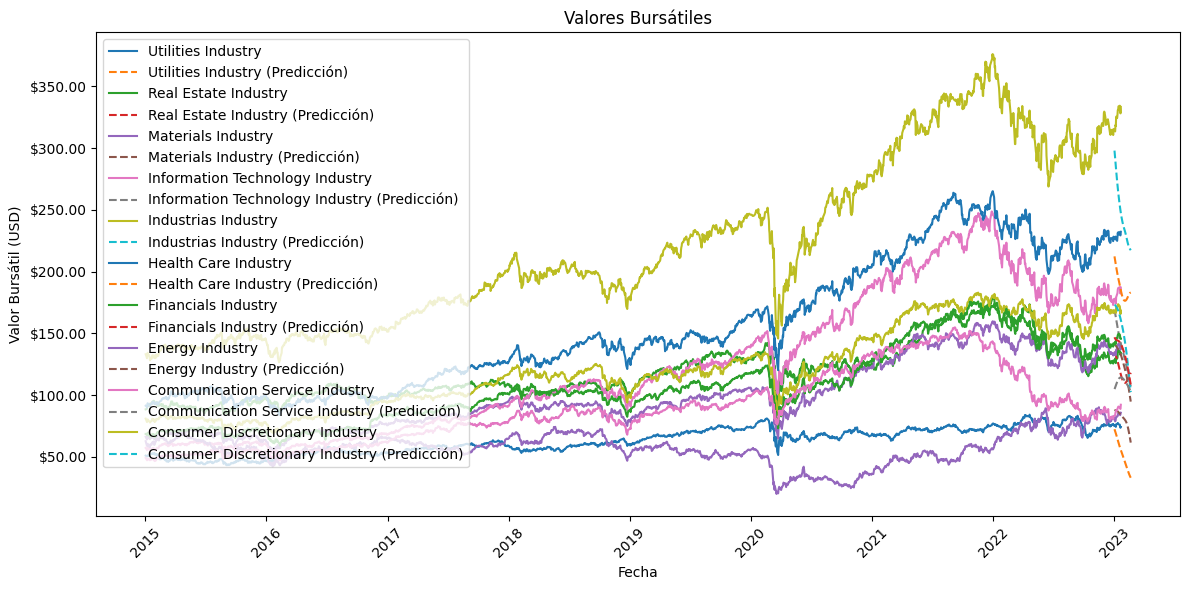

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Cargar los datos desde un archivo Excel
data = pd.read_excel('/content/Industry SP500 Mean.xlsx', parse_dates=['Date'])

# Seleccionar las columnas con los valores de las empresas
company_columns = ['Utilities Industry', 'Real Estate Industry', 'Materials Industry', 'Information Technology Industry', 'Industrias Industry',
                   'Health Care Industry', 'Financials Industry', 'Energy Industry', 'Communication Service Industry', 'Consumer Discretionary Industry' ]

# Obtener los valores de las empresas como una matriz 2D
values = data[company_columns].values

# Normalizar los datos
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_values = scaler.fit_transform(values)

# Dividir los datos en conjuntos de entrenamiento y prueba
train_size = int(len(scaled_values) * 0.8)
train_data, test_data = scaled_values[:train_size], scaled_values[train_size:]

# Crear conjuntos de datos de entrada y salida
def create_dataset(data, window_size):
    X, y = [], []
    for i in range(len(data) - window_size - 1):
        X.append(data[i:(i + window_size), :])
        y.append(data[i + window_size, :])
    return np.array(X), np.array(y)

window_size = 30  # Tamaño de la ventana para el conjunto de datos de entrada
X_train, y_train = create_dataset(train_data, window_size)
X_test, y_test = create_dataset(test_data, window_size)

# Crear el modelo de red neuronal
model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(300, activation='relu', input_shape=(window_size, len(company_columns))),
    tf.keras.layers.Dense(len(company_columns))
])

# Compilar el modelo
model.compile(optimizer='adam', loss='mean_squared_error')

# Entrenar el modelo
model.fit(X_train, y_train, epochs=60, batch_size=50)

# Realizar predicciones
train_predictions = model.predict(X_train)
test_predictions = model.predict(X_test)

# Invertir la normalización de los datos
train_predictions = scaler.inverse_transform(train_predictions)
y_train = scaler.inverse_transform(y_train)
test_predictions = scaler.inverse_transform(test_predictions)
y_test = scaler.inverse_transform(y_test)

# Calcular el error RMSE
train_rmse = np.sqrt(mean_squared_error(y_train, train_predictions))
test_rmse = np.sqrt(mean_squared_error(y_test, test_predictions))
print("RMSE (Entrenamiento):", train_rmse)
print("RMSE (Prueba):", test_rmse)

# Obtener la ventana de datos de prueba más reciente
last_window = scaled_values[-window_size:, :]

# Realizar predicción de los próximos 50 días
future_predictions = []
for _ in range(50):
    future_prediction = model.predict(last_window.reshape(1, window_size, len(company_columns)))
    future_predictions.append(future_prediction)
    last_window = np.append(last_window[1:, :], future_prediction, axis=0)

# Invertir la normalización de las predicciones futuras
future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1, len(company_columns)))

# Crear las fechas para los próximos 50 días a partir del 1 de enero de 2023
start_date = pd.to_datetime('2023-01-01')
date_range = pd.date_range(start=start_date, periods=50)

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# Graficar los resultados
plt.figure(figsize=(12, 6))
for i, company in enumerate(company_columns):
    plt.plot(data['Date'], values[:, i], label=company)
    plt.plot(date_range, future_predictions[:, i], label=f'{company} (Predicción)', linestyle='--')

# Función para formatear los valores en dólares
def dollar_format(x, pos):
    return f'${x:.2f}'

# Configurar el formateador de ejes para mostrar valores en dólares
formatter = ticker.FuncFormatter(dollar_format)
plt.gca().yaxis.set_major_formatter(formatter)

plt.xlabel('Fecha')
plt.ylabel('Valor Bursátil (USD)')
plt.title('Valores Bursátiles')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


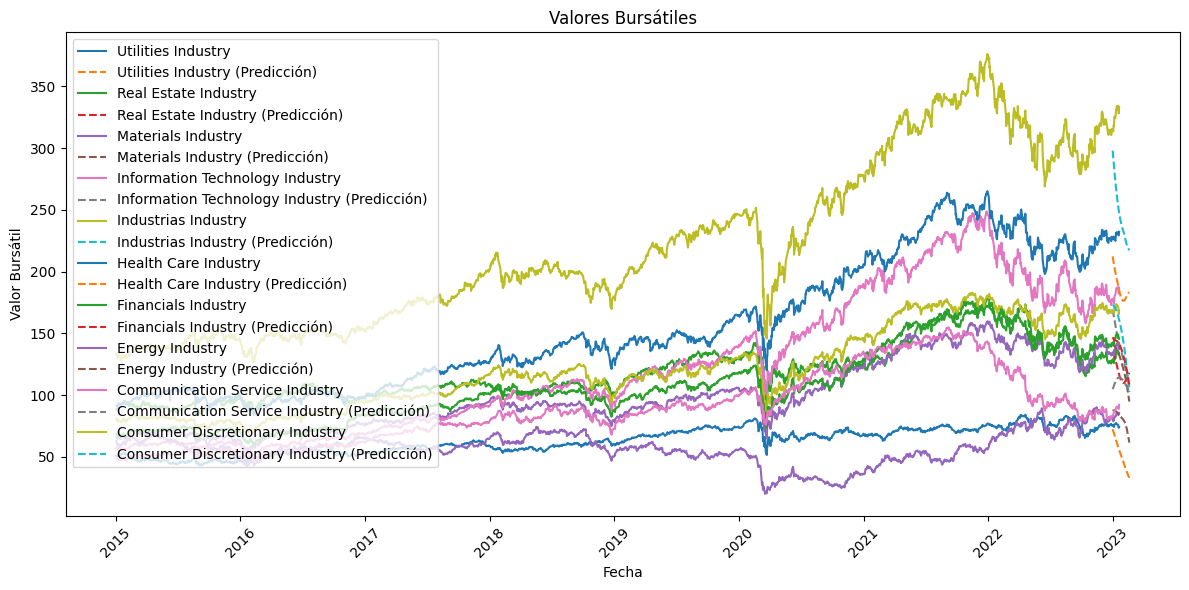

In [ ]:
# Graficar los resultados
plt.figure(figsize=(12, 6))
for i, company in enumerate(company_columns):
    plt.plot(data['Date'], values[:, i], label=company)
    plt.plot(date_range, future_predictions[:, i], label=f'{company} (Predicción)', linestyle='--')
plt.xlabel('Fecha')
plt.ylabel('Valor Bursátil')
plt.title('Valores Bursátiles')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

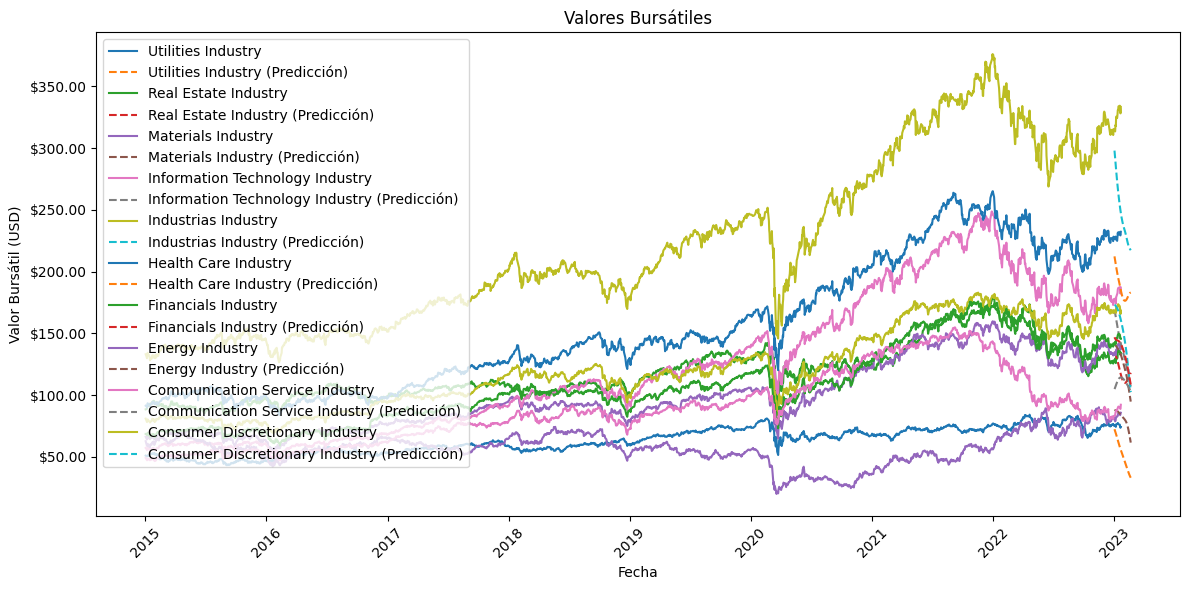

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# Graficar los resultados
plt.figure(figsize=(12, 6))
for i, company in enumerate(company_columns):
    plt.plot(data['Date'], values[:, i], label=company)
    plt.plot(date_range, future_predictions[:, i], label=f'{company} (Predicción)', linestyle='--')

# Función para formatear los valores en dólares
def dollar_format(x, pos):
    return f'${x:.2f}'

# Configurar el formateador de ejes para mostrar valores en dólares
formatter = ticker.FuncFormatter(dollar_format)
plt.gca().yaxis.set_major_formatter(formatter)

plt.xlabel('Fecha')
plt.ylabel('Valor Bursátil (USD)')
plt.title('Valores Bursátiles')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

##Consumer Discretionary Industry


Epoch 1/60
36/36 [==============================] - 7s 152ms/step - loss: 0.0175
Epoch 2/60
36/36 [==============================] - 4s 124ms/step - loss: 7.7642e-04
Epoch 3/60
36/36 [==============================] - 6s 158ms/step - loss: 5.4905e-04
Epoch 4/60
36/36 [==============================] - 4s 124ms/step - loss: 5.5420e-04
Epoch 5/60
36/36 [==============================] - 4s 123ms/step - loss: 4.9262e-04
Epoch 6/60
36/36 [==============================] - 6s 159ms/step - loss: 4.7580e-04
Epoch 7/60
36/36 [==============================] - 5s 125ms/step - loss: 4.5431e-04
Epoch 8/60
36/36 [==============================] - 5s 136ms/step - loss: 4.4581e-04
Epoch 9/60
36/36 [==============================] - 5s 145ms/step - loss: 4.0623e-04
Epoch 10/60
36/36 [==============================] - 4s 119ms/step - loss: 3.8632e-04
Epoch 11/60
36/36 [==============================] - 6s 156ms/step - loss: 3.6549e-04
Epoch 12/60
36/36 [==============================] - 4s 123ms/step 

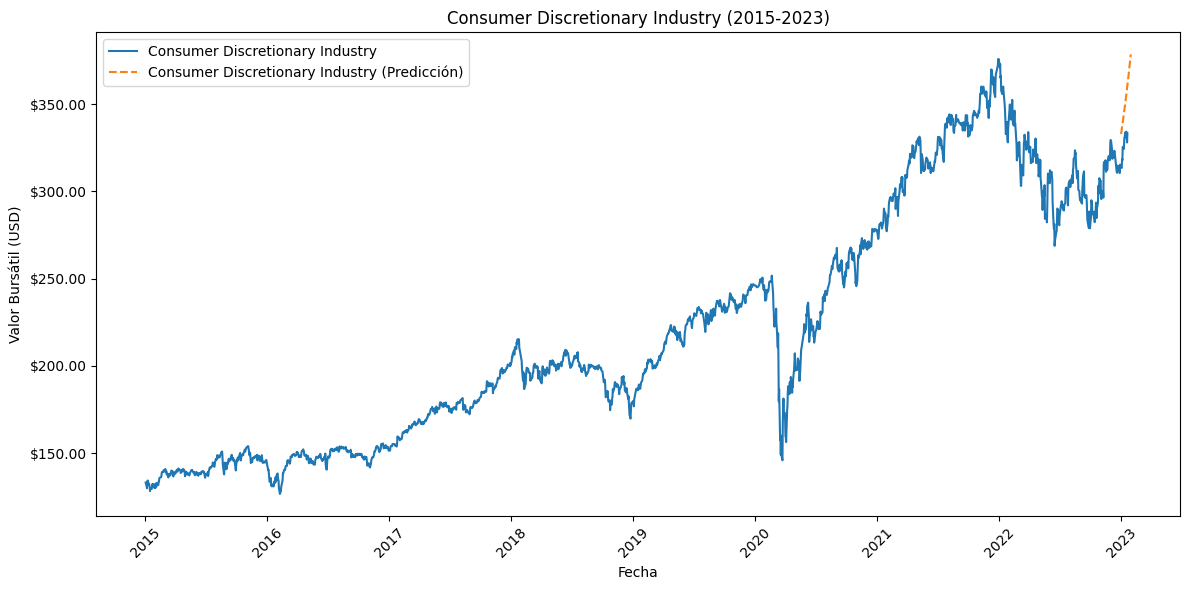

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Cargar los datos desde un archivo Excel
data = pd.read_excel('/content/Industry SP500 Mean.xlsx', parse_dates=['Date'])

# Seleccionar las columnas con los valores de las empresas
company_columns = ['Consumer Discretionary Industry' ]

# Obtener los valores de las empresas como una matriz 2D
values = data[company_columns].values

# Normalizar los datos
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_values = scaler.fit_transform(values)

# Dividir los datos en conjuntos de entrenamiento y prueba
train_size = int(len(scaled_values) * 0.8)
train_data, test_data = scaled_values[:train_size], scaled_values[train_size:]

# Crear conjuntos de datos de entrada y salida
def create_dataset(data, window_size):
    X, y = [], []
    for i in range(len(data) - window_size - 1):
        X.append(data[i:(i + window_size), :])
        y.append(data[i + window_size, :])
    return np.array(X), np.array(y)

window_size = 30  # Tamaño de la ventana para el conjunto de datos de entrada
X_train, y_train = create_dataset(train_data, window_size)
X_test, y_test = create_dataset(test_data, window_size)

# Crear el modelo de red neuronal
model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(300, activation='relu', input_shape=(window_size, len(company_columns))),
    tf.keras.layers.Dense(len(company_columns))
])

# Compilar el modelo
model.compile(optimizer='adam', loss='mean_squared_error')

# Entrenar el modelo
model.fit(X_train, y_train, epochs=60, batch_size=45)

# Realizar predicciones
train_predictions = model.predict(X_train)
test_predictions = model.predict(X_test)

# Invertir la normalización de los datos
train_predictions = scaler.inverse_transform(train_predictions)
y_train = scaler.inverse_transform(y_train)
test_predictions = scaler.inverse_transform(test_predictions)
y_test = scaler.inverse_transform(y_test)

# Calcular el error RMSE
train_rmse = np.sqrt(mean_squared_error(y_train, train_predictions))
test_rmse = np.sqrt(mean_squared_error(y_test, test_predictions))
print("RMSE (Entrenamiento):", train_rmse)
print("RMSE (Prueba):", test_rmse)

# Obtener la ventana de datos de prueba más reciente
last_window = scaled_values[-window_size:, :]

# Realizar predicción de los próximos 50 días
future_predictions = []
for _ in range(30):
    future_prediction = model.predict(last_window.reshape(1, window_size, len(company_columns)))
    future_predictions.append(future_prediction)
    last_window = np.append(last_window[1:, :], future_prediction, axis=0)

# Invertir la normalización de las predicciones futuras
future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1, len(company_columns)))

# Crear las fechas para los próximos 50 días a partir del 1 de enero de 2023
start_date = pd.to_datetime('2023-01-01')
date_range = pd.date_range(start=start_date, periods=30)

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# Graficar los resultados
plt.figure(figsize=(12, 6))
for i, company in enumerate(company_columns):
    plt.plot(data['Date'], values[:, i], label=company)
    plt.plot(date_range, future_predictions[:, i], label=f'{company} (Predicción)', linestyle='--')

# Función para formatear los valores en dólares
def dollar_format(x, pos):
    return f'${x:.2f}'

# Configurar el formateador de ejes para mostrar valores en dólares
formatter = ticker.FuncFormatter(dollar_format)
plt.gca().yaxis.set_major_formatter(formatter)

plt.xlabel('Fecha')
plt.ylabel('Valor Bursátil (USD)')
plt.title('Consumer Discretionary Industry (2015-2023)')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


##Consumer Staples Industry

Epoch 1/60
32/32 [==============================] - 8s 175ms/step - loss: 0.0245
Epoch 2/60
32/32 [==============================] - 4s 138ms/step - loss: 0.0015
Epoch 3/60
32/32 [==============================] - 4s 139ms/step - loss: 7.0648e-04
Epoch 4/60
32/32 [==============================] - 6s 174ms/step - loss: 6.6430e-04
Epoch 5/60
32/32 [==============================] - 4s 139ms/step - loss: 6.5177e-04
Epoch 6/60
32/32 [==============================] - 5s 145ms/step - loss: 6.3987e-04
Epoch 7/60
32/32 [==============================] - 5s 170ms/step - loss: 6.0166e-04
Epoch 8/60
32/32 [==============================] - 4s 139ms/step - loss: 5.8711e-04
Epoch 9/60
32/32 [==============================] - 6s 177ms/step - loss: 5.3769e-04
Epoch 10/60
32/32 [==============================] - 4s 139ms/step - loss: 5.2086e-04
Epoch 11/60
32/32 [==============================] - 4s 137ms/step - loss: 4.9022e-04
Epoch 12/60
32/32 [==============================] - 6s 174ms/step - lo

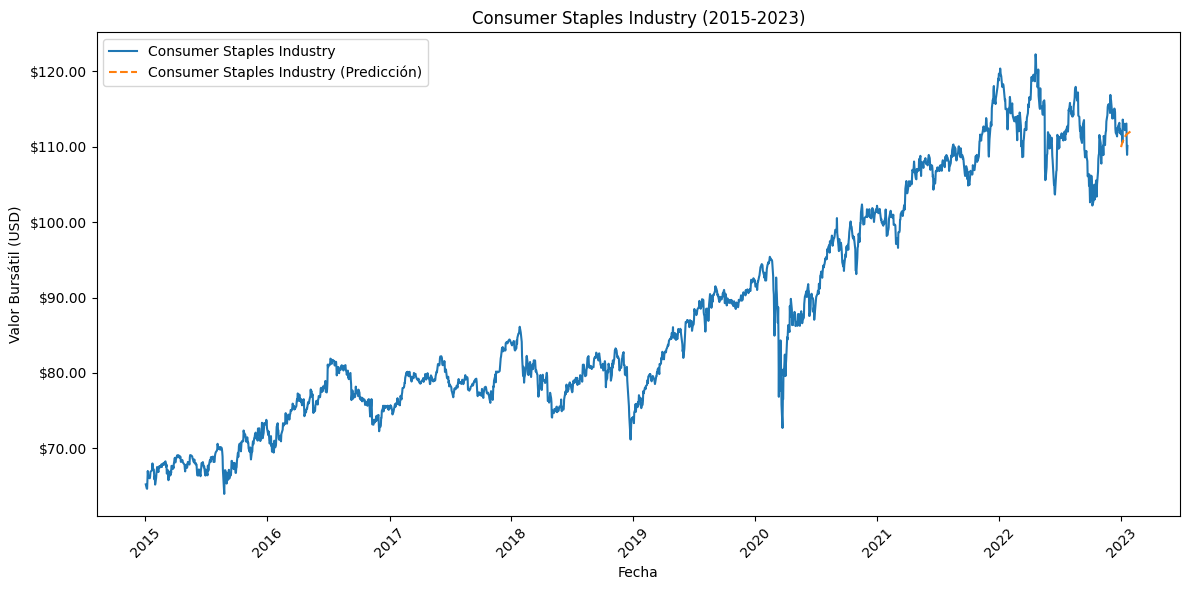

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Cargar los datos desde un archivo Excel
data = pd.read_excel('/content/Industry SP500 Mean.xlsx', parse_dates=['Date'])

# Seleccionar las columnas con los valores de las empresas
company_columns = ['Consumer Staples Industry' ]

# Obtener los valores de las empresas como una matriz 2D
values = data[company_columns].values

# Normalizar los datos
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_values = scaler.fit_transform(values)

# Dividir los datos en conjuntos de entrenamiento y prueba
train_size = int(len(scaled_values) * 0.8)
train_data, test_data = scaled_values[:train_size], scaled_values[train_size:]

# Crear conjuntos de datos de entrada y salida
def create_dataset(data, window_size):
    X, y = [], []
    for i in range(len(data) - window_size - 1):
        X.append(data[i:(i + window_size), :])
        y.append(data[i + window_size, :])
    return np.array(X), np.array(y)

window_size = 30  # Tamaño de la ventana para el conjunto de datos de entrada
X_train, y_train = create_dataset(train_data, window_size)
X_test, y_test = create_dataset(test_data, window_size)

# Crear el modelo de red neuronal
model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(300, activation='relu', input_shape=(window_size, len(company_columns))),
    tf.keras.layers.Dense(len(company_columns))
])

# Compilar el modelo
model.compile(optimizer='adam', loss='mean_squared_error')

# Entrenar el modelo
model.fit(X_train, y_train, epochs=60, batch_size=50)

# Realizar predicciones
train_predictions = model.predict(X_train)
test_predictions = model.predict(X_test)

# Invertir la normalización de los datos
train_predictions = scaler.inverse_transform(train_predictions)
y_train = scaler.inverse_transform(y_train)
test_predictions = scaler.inverse_transform(test_predictions)
y_test = scaler.inverse_transform(y_test)

# Calcular el error RMSE
train_rmse = np.sqrt(mean_squared_error(y_train, train_predictions))
test_rmse = np.sqrt(mean_squared_error(y_test, test_predictions))
print("RMSE (Entrenamiento):", train_rmse)
print("RMSE (Prueba):", test_rmse)

# Obtener la ventana de datos de prueba más reciente
last_window = scaled_values[-window_size:, :]

# Realizar predicción de los próximos 50 días
future_predictions = []
for _ in range(30):
    future_prediction = model.predict(last_window.reshape(1, window_size, len(company_columns)))
    future_predictions.append(future_prediction)
    last_window = np.append(last_window[1:, :], future_prediction, axis=0)

# Invertir la normalización de las predicciones futuras
future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1, len(company_columns)))

# Crear las fechas para los próximos 50 días a partir del 1 de enero de 2023
start_date = pd.to_datetime('2023-01-01')
date_range = pd.date_range(start=start_date, periods=30)

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# Graficar los resultados
plt.figure(figsize=(12, 6))
for i, company in enumerate(company_columns):
    plt.plot(data['Date'], values[:, i], label=company)
    plt.plot(date_range, future_predictions[:, i], label=f'{company} (Predicción)', linestyle='--')

# Función para formatear los valores en dólares
def dollar_format(x, pos):
    return f'${x:.2f}'

# Configurar el formateador de ejes para mostrar valores en dólares
formatter = ticker.FuncFormatter(dollar_format)
plt.gca().yaxis.set_major_formatter(formatter)

plt.xlabel('Fecha')
plt.ylabel('Valor Bursátil (USD)')
plt.title('Consumer Staples Industry (2015-2023)')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


##Health Care Industry

Epoch 1/60
32/32 [==============================] - 6s 136ms/step - loss: 0.0204
Epoch 2/60
32/32 [==============================] - 6s 173ms/step - loss: 6.6817e-04
Epoch 3/60
32/32 [==============================] - 4s 139ms/step - loss: 4.2611e-04
Epoch 4/60
32/32 [==============================] - 4s 135ms/step - loss: 4.1014e-04
Epoch 5/60
32/32 [==============================] - 6s 174ms/step - loss: 3.9773e-04
Epoch 6/60
32/32 [==============================] - 4s 136ms/step - loss: 3.8218e-04
Epoch 7/60
32/32 [==============================] - 4s 137ms/step - loss: 3.8900e-04
Epoch 8/60
32/32 [==============================] - 5s 170ms/step - loss: 3.5148e-04
Epoch 9/60
32/32 [==============================] - 4s 136ms/step - loss: 3.4082e-04
Epoch 10/60
32/32 [==============================] - 5s 161ms/step - loss: 3.3710e-04
Epoch 11/60
32/32 [==============================] - 5s 146ms/step - loss: 4.0451e-04
Epoch 12/60
32/32 [==============================] - 4s 136ms/step 

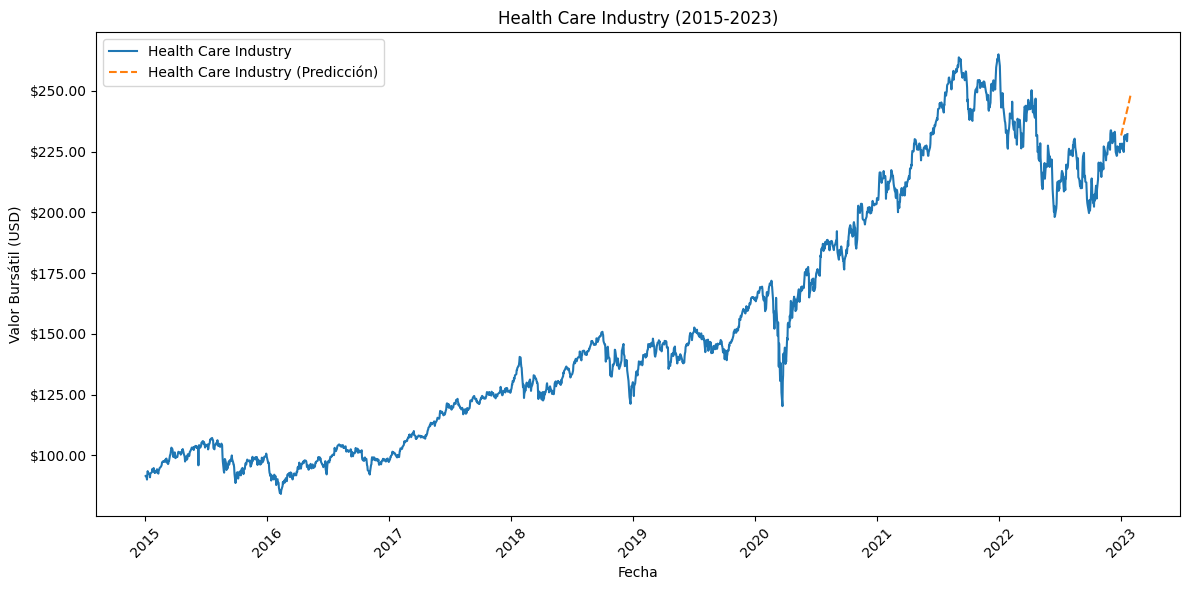

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Cargar los datos desde un archivo Excel
data = pd.read_excel('/content/Industry SP500 Mean.xlsx', parse_dates=['Date'])

# Seleccionar las columnas con los valores de las empresas
company_columns = ['Health Care Industry' ]

# Obtener los valores de las empresas como una matriz 2D
values = data[company_columns].values

# Normalizar los datos
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_values = scaler.fit_transform(values)

# Dividir los datos en conjuntos de entrenamiento y prueba
train_size = int(len(scaled_values) * 0.8)
train_data, test_data = scaled_values[:train_size], scaled_values[train_size:]

# Crear conjuntos de datos de entrada y salida
def create_dataset(data, window_size):
    X, y = [], []
    for i in range(len(data) - window_size - 1):
        X.append(data[i:(i + window_size), :])
        y.append(data[i + window_size, :])
    return np.array(X), np.array(y)

window_size = 30  # Tamaño de la ventana para el conjunto de datos de entrada
X_train, y_train = create_dataset(train_data, window_size)
X_test, y_test = create_dataset(test_data, window_size)

# Crear el modelo de red neuronal
model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(300, activation='relu', input_shape=(window_size, len(company_columns))),
    tf.keras.layers.Dense(len(company_columns))
])

# Compilar el modelo
model.compile(optimizer='adam', loss='mean_squared_error')

# Entrenar el modelo
model.fit(X_train, y_train, epochs=60, batch_size=50)

# Realizar predicciones
train_predictions = model.predict(X_train)
test_predictions = model.predict(X_test)

# Invertir la normalización de los datos
train_predictions = scaler.inverse_transform(train_predictions)
y_train = scaler.inverse_transform(y_train)
test_predictions = scaler.inverse_transform(test_predictions)
y_test = scaler.inverse_transform(y_test)

# Calcular el error RMSE
train_rmse = np.sqrt(mean_squared_error(y_train, train_predictions))
test_rmse = np.sqrt(mean_squared_error(y_test, test_predictions))
print("RMSE (Entrenamiento):", train_rmse)
print("RMSE (Prueba):", test_rmse)

# Obtener la ventana de datos de prueba más reciente
last_window = scaled_values[-window_size:, :]

# Realizar predicción de los próximos 50 días
future_predictions = []
for _ in range(30):
    future_prediction = model.predict(last_window.reshape(1, window_size, len(company_columns)))
    future_predictions.append(future_prediction)
    last_window = np.append(last_window[1:, :], future_prediction, axis=0)

# Invertir la normalización de las predicciones futuras
future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1, len(company_columns)))

# Crear las fechas para los próximos 50 días a partir del 1 de enero de 2023
start_date = pd.to_datetime('2023-01-01')
date_range = pd.date_range(start=start_date, periods=30)

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# Graficar los resultados
plt.figure(figsize=(12, 6))
for i, company in enumerate(company_columns):
    plt.plot(data['Date'], values[:, i], label=company)
    plt.plot(date_range, future_predictions[:, i], label=f'{company} (Predicción)', linestyle='--')

# Función para formatear los valores en dólares
def dollar_format(x, pos):
    return f'${x:.2f}'

# Configurar el formateador de ejes para mostrar valores en dólares
formatter = ticker.FuncFormatter(dollar_format)
plt.gca().yaxis.set_major_formatter(formatter)

plt.xlabel('Fecha')
plt.ylabel('Valor Bursátil (USD)')
plt.title('Health Care Industry (2015-2023)')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

##Industrials Industry

Epoch 1/60
32/32 [==============================] - 7s 173ms/step - loss: 0.0204
Epoch 2/60
32/32 [==============================] - 4s 135ms/step - loss: 8.5263e-04
Epoch 3/60
32/32 [==============================] - 4s 139ms/step - loss: 6.5127e-04
Epoch 4/60
32/32 [==============================] - 5s 164ms/step - loss: 6.3263e-04
Epoch 5/60
32/32 [==============================] - 4s 132ms/step - loss: 6.0179e-04
Epoch 6/60
32/32 [==============================] - 5s 156ms/step - loss: 5.9987e-04
Epoch 7/60
32/32 [==============================] - 5s 147ms/step - loss: 5.4668e-04
Epoch 8/60
32/32 [==============================] - 4s 135ms/step - loss: 5.2162e-04
Epoch 9/60
32/32 [==============================] - 5s 172ms/step - loss: 5.4079e-04
Epoch 10/60
32/32 [==============================] - 4s 133ms/step - loss: 4.9766e-04
Epoch 11/60
32/32 [==============================] - 4s 134ms/step - loss: 5.4584e-04
Epoch 12/60
32/32 [==============================] - 5s 170ms/step 

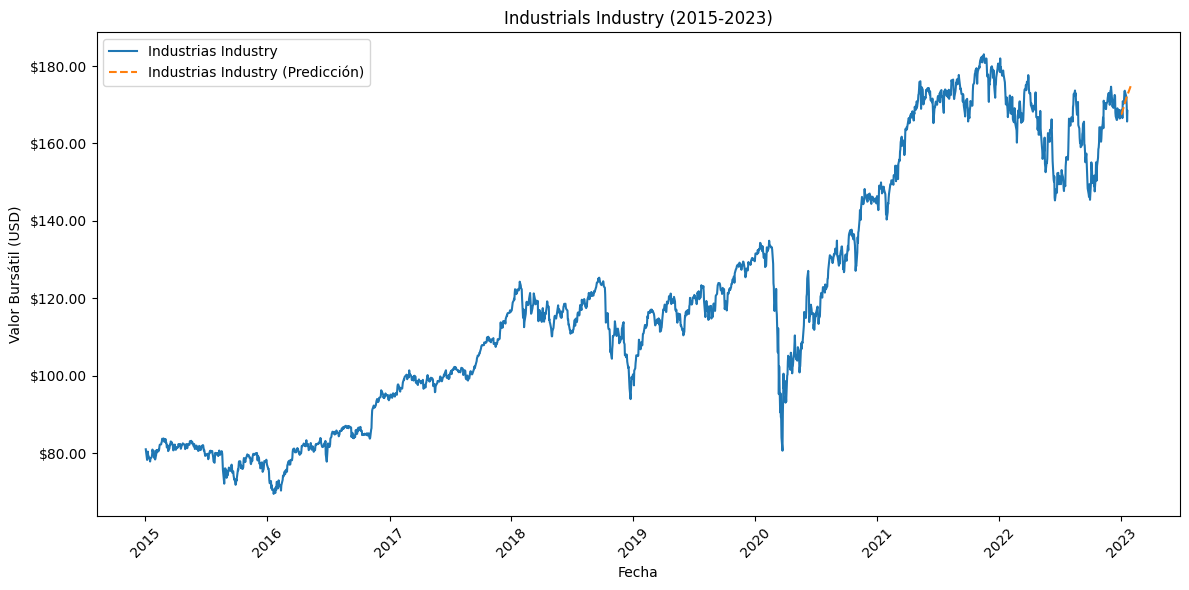

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Cargar los datos desde un archivo Excel
data = pd.read_excel('/content/Industry SP500 Mean.xlsx', parse_dates=['Date'])

# Seleccionar las columnas con los valores de las empresas
company_columns = ['Industrias Industry' ]

# Obtener los valores de las empresas como una matriz 2D
values = data[company_columns].values

# Normalizar los datos
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_values = scaler.fit_transform(values)

# Dividir los datos en conjuntos de entrenamiento y prueba
train_size = int(len(scaled_values) * 0.8)
train_data, test_data = scaled_values[:train_size], scaled_values[train_size:]

# Crear conjuntos de datos de entrada y salida
def create_dataset(data, window_size):
    X, y = [], []
    for i in range(len(data) - window_size - 1):
        X.append(data[i:(i + window_size), :])
        y.append(data[i + window_size, :])
    return np.array(X), np.array(y)

window_size = 30  # Tamaño de la ventana para el conjunto de datos de entrada
X_train, y_train = create_dataset(train_data, window_size)
X_test, y_test = create_dataset(test_data, window_size)

# Crear el modelo de red neuronal
model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(300, activation='relu', input_shape=(window_size, len(company_columns))),
    tf.keras.layers.Dense(len(company_columns))
])

# Compilar el modelo
model.compile(optimizer='adam', loss='mean_squared_error')

# Entrenar el modelo
model.fit(X_train, y_train, epochs=60, batch_size=50)

# Realizar predicciones
train_predictions = model.predict(X_train)
test_predictions = model.predict(X_test)

# Invertir la normalización de los datos
train_predictions = scaler.inverse_transform(train_predictions)
y_train = scaler.inverse_transform(y_train)
test_predictions = scaler.inverse_transform(test_predictions)
y_test = scaler.inverse_transform(y_test)

# Calcular el error RMSE
train_rmse = np.sqrt(mean_squared_error(y_train, train_predictions))
test_rmse = np.sqrt(mean_squared_error(y_test, test_predictions))
print("RMSE (Entrenamiento):", train_rmse)
print("RMSE (Prueba):", test_rmse)

# Obtener la ventana de datos de prueba más reciente
last_window = scaled_values[-window_size:, :]

# Realizar predicción de los próximos 50 días
future_predictions = []
for _ in range(30):
    future_prediction = model.predict(last_window.reshape(1, window_size, len(company_columns)))
    future_predictions.append(future_prediction)
    last_window = np.append(last_window[1:, :], future_prediction, axis=0)

# Invertir la normalización de las predicciones futuras
future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1, len(company_columns)))

# Crear las fechas para los próximos 50 días a partir del 1 de enero de 2023
start_date = pd.to_datetime('2023-01-01')
date_range = pd.date_range(start=start_date, periods=30)

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# Graficar los resultados
plt.figure(figsize=(12, 6))
for i, company in enumerate(company_columns):
    plt.plot(data['Date'], values[:, i], label=company)
    plt.plot(date_range, future_predictions[:, i], label=f'{company} (Predicción)', linestyle='--')

# Función para formatear los valores en dólares
def dollar_format(x, pos):
    return f'${x:.2f}'

# Configurar el formateador de ejes para mostrar valores en dólares
formatter = ticker.FuncFormatter(dollar_format)
plt.gca().yaxis.set_major_formatter(formatter)

plt.xlabel('Fecha')
plt.ylabel('Valor Bursátil (USD)')
plt.title('Industrials Industry (2015-2023)')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

##Information Technology Industry

Epoch 1/60
32/32 [==============================] - 6s 138ms/step - loss: 0.0187
Epoch 2/60
32/32 [==============================] - 6s 175ms/step - loss: 7.0051e-04
Epoch 3/60
32/32 [==============================] - 4s 137ms/step - loss: 3.2367e-04
Epoch 4/60
32/32 [==============================] - 5s 157ms/step - loss: 3.0185e-04
Epoch 5/60
32/32 [==============================] - 5s 149ms/step - loss: 3.0235e-04
Epoch 6/60
32/32 [==============================] - 4s 138ms/step - loss: 3.4249e-04
Epoch 7/60
32/32 [==============================] - 6s 176ms/step - loss: 2.6970e-04
Epoch 8/60
32/32 [==============================] - 4s 138ms/step - loss: 2.5424e-04
Epoch 9/60
32/32 [==============================] - 4s 139ms/step - loss: 2.5222e-04
Epoch 10/60
32/32 [==============================] - 6s 176ms/step - loss: 2.3397e-04
Epoch 11/60
32/32 [==============================] - 4s 137ms/step - loss: 2.4851e-04
Epoch 12/60
32/32 [==============================] - 6s 194ms/step 

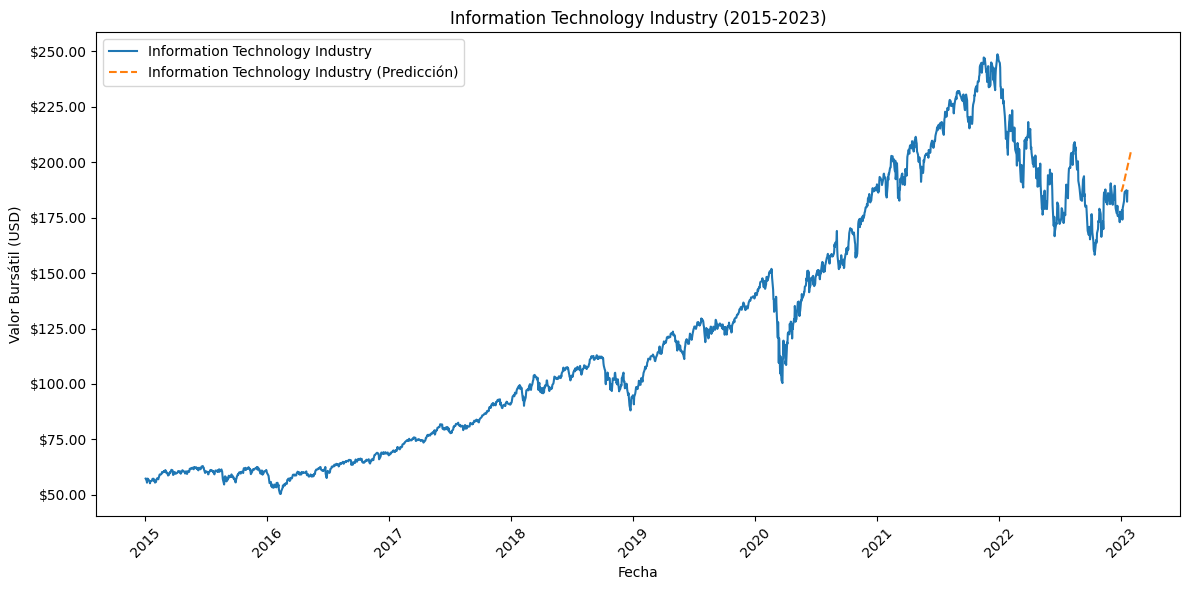

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Cargar los datos desde un archivo Excel
data = pd.read_excel('/content/Industry SP500 Mean.xlsx', parse_dates=['Date'])

# Seleccionar las columnas con los valores de las empresas
company_columns = ['Information Technology Industry' ]

# Obtener los valores de las empresas como una matriz 2D
values = data[company_columns].values

# Normalizar los datos
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_values = scaler.fit_transform(values)

# Dividir los datos en conjuntos de entrenamiento y prueba
train_size = int(len(scaled_values) * 0.8)
train_data, test_data = scaled_values[:train_size], scaled_values[train_size:]

# Crear conjuntos de datos de entrada y salida
def create_dataset(data, window_size):
    X, y = [], []
    for i in range(len(data) - window_size - 1):
        X.append(data[i:(i + window_size), :])
        y.append(data[i + window_size, :])
    return np.array(X), np.array(y)

window_size = 30  # Tamaño de la ventana para el conjunto de datos de entrada
X_train, y_train = create_dataset(train_data, window_size)
X_test, y_test = create_dataset(test_data, window_size)

# Crear el modelo de red neuronal
model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(300, activation='relu', input_shape=(window_size, len(company_columns))),
    tf.keras.layers.Dense(len(company_columns))
])

# Compilar el modelo
model.compile(optimizer='adam', loss='mean_squared_error')

# Entrenar el modelo
model.fit(X_train, y_train, epochs=60, batch_size=50)

# Realizar predicciones
train_predictions = model.predict(X_train)
test_predictions = model.predict(X_test)

# Invertir la normalización de los datos
train_predictions = scaler.inverse_transform(train_predictions)
y_train = scaler.inverse_transform(y_train)
test_predictions = scaler.inverse_transform(test_predictions)
y_test = scaler.inverse_transform(y_test)

# Calcular el error RMSE
train_rmse = np.sqrt(mean_squared_error(y_train, train_predictions))
test_rmse = np.sqrt(mean_squared_error(y_test, test_predictions))
print("RMSE (Entrenamiento):", train_rmse)
print("RMSE (Prueba):", test_rmse)

# Obtener la ventana de datos de prueba más reciente
last_window = scaled_values[-window_size:, :]

# Realizar predicción de los próximos 50 días
future_predictions = []
for _ in range(30):
    future_prediction = model.predict(last_window.reshape(1, window_size, len(company_columns)))
    future_predictions.append(future_prediction)
    last_window = np.append(last_window[1:, :], future_prediction, axis=0)

# Invertir la normalización de las predicciones futuras
future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1, len(company_columns)))

# Crear las fechas para los próximos 50 días a partir del 1 de enero de 2023
start_date = pd.to_datetime('2023-01-01')
date_range = pd.date_range(start=start_date, periods=30)

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# Graficar los resultados
plt.figure(figsize=(12, 6))
for i, company in enumerate(company_columns):
    plt.plot(data['Date'], values[:, i], label=company)
    plt.plot(date_range, future_predictions[:, i], label=f'{company} (Predicción)', linestyle='--')

# Función para formatear los valores en dólares
def dollar_format(x, pos):
    return f'${x:.2f}'

# Configurar el formateador de ejes para mostrar valores en dólares
formatter = ticker.FuncFormatter(dollar_format)
plt.gca().yaxis.set_major_formatter(formatter)

plt.xlabel('Fecha')
plt.ylabel('Valor Bursátil (USD)')
plt.title('Information Technology Industry (2015-2023)')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

##Materials Industry

Epoch 1/60
32/32 [==============================] - 7s 136ms/step - loss: 0.0168
Epoch 2/60
32/32 [==============================] - 5s 172ms/step - loss: 8.6758e-04
Epoch 3/60
32/32 [==============================] - 4s 139ms/step - loss: 5.4652e-04
Epoch 4/60
32/32 [==============================] - 4s 139ms/step - loss: 5.1216e-04
Epoch 5/60
32/32 [==============================] - 6s 178ms/step - loss: 5.3446e-04
Epoch 6/60
32/32 [==============================] - 4s 138ms/step - loss: 4.9025e-04
Epoch 7/60
32/32 [==============================] - 5s 149ms/step - loss: 4.7505e-04
Epoch 8/60
32/32 [==============================] - 5s 167ms/step - loss: 4.5577e-04
Epoch 9/60
32/32 [==============================] - 5s 141ms/step - loss: 4.0888e-04
Epoch 10/60
32/32 [==============================] - 6s 180ms/step - loss: 4.2781e-04
Epoch 11/60
32/32 [==============================] - 4s 140ms/step - loss: 4.2418e-04
Epoch 12/60
32/32 [==============================] - 4s 140ms/step 

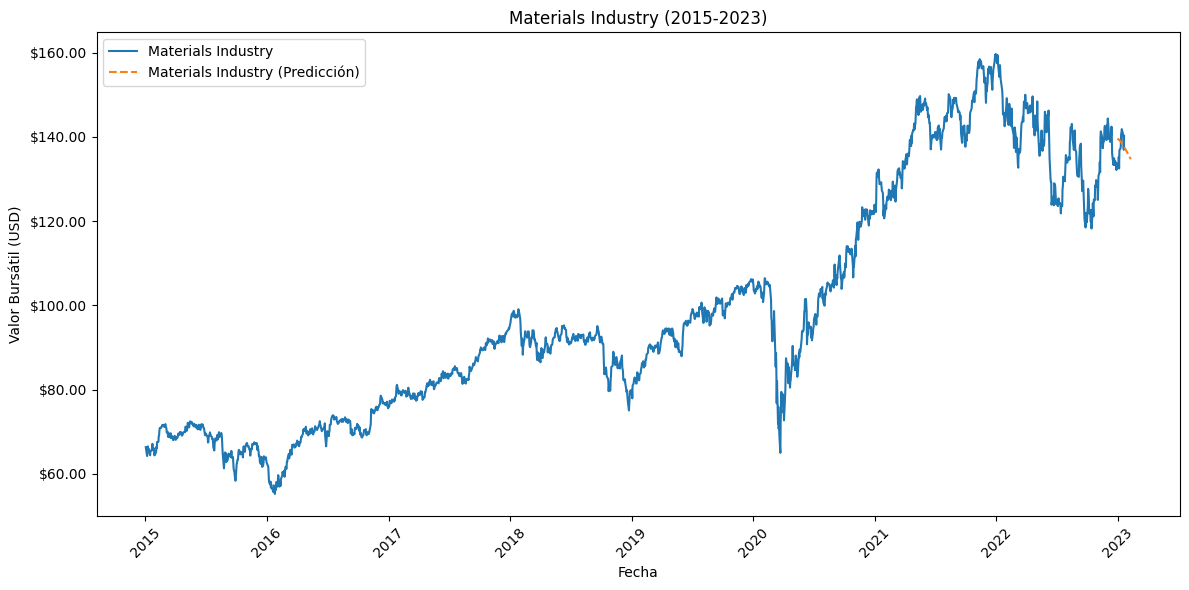

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Cargar los datos desde un archivo Excel
data = pd.read_excel('/content/Industry SP500 Mean.xlsx', parse_dates=['Date'])

# Seleccionar las columnas con los valores de las empresas
company_columns = ['Materials Industry' ]

# Obtener los valores de las empresas como una matriz 2D
values = data[company_columns].values

# Normalizar los datos
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_values = scaler.fit_transform(values)

# Dividir los datos en conjuntos de entrenamiento y prueba
train_size = int(len(scaled_values) * 0.8)
train_data, test_data = scaled_values[:train_size], scaled_values[train_size:]

# Crear conjuntos de datos de entrada y salida
def create_dataset(data, window_size):
    X, y = [], []
    for i in range(len(data) - window_size - 1):
        X.append(data[i:(i + window_size), :])
        y.append(data[i + window_size, :])
    return np.array(X), np.array(y)

window_size = 30  # Tamaño de la ventana para el conjunto de datos de entrada
X_train, y_train = create_dataset(train_data, window_size)
X_test, y_test = create_dataset(test_data, window_size)

# Crear el modelo de red neuronal
model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(300, activation='relu', input_shape=(window_size, len(company_columns))),
    tf.keras.layers.Dense(len(company_columns))
])

# Compilar el modelo
model.compile(optimizer='adam', loss='mean_squared_error')

# Entrenar el modelo
model.fit(X_train, y_train, epochs=60, batch_size=50)

# Realizar predicciones
train_predictions = model.predict(X_train)
test_predictions = model.predict(X_test)

# Invertir la normalización de los datos
train_predictions = scaler.inverse_transform(train_predictions)
y_train = scaler.inverse_transform(y_train)
test_predictions = scaler.inverse_transform(test_predictions)
y_test = scaler.inverse_transform(y_test)

# Calcular el error RMSE
train_rmse = np.sqrt(mean_squared_error(y_train, train_predictions))
test_rmse = np.sqrt(mean_squared_error(y_test, test_predictions))
print("RMSE (Entrenamiento):", train_rmse)
print("RMSE (Prueba):", test_rmse)

# Obtener la ventana de datos de prueba más reciente
last_window = scaled_values[-window_size:, :]

# Realizar predicción de los próximos 50 días
future_predictions = []
for _ in range(40):
    future_prediction = model.predict(last_window.reshape(1, window_size, len(company_columns)))
    future_predictions.append(future_prediction)
    last_window = np.append(last_window[1:, :], future_prediction, axis=0)

# Invertir la normalización de las predicciones futuras
future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1, len(company_columns)))

# Crear las fechas para los próximos 50 días a partir del 1 de enero de 2023
start_date = pd.to_datetime('2023-01-01')
date_range = pd.date_range(start=start_date, periods=40)

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# Graficar los resultados
plt.figure(figsize=(12, 6))
for i, company in enumerate(company_columns):
    plt.plot(data['Date'], values[:, i], label=company)
    plt.plot(date_range, future_predictions[:, i], label=f'{company} (Predicción)', linestyle='--')

# Función para formatear los valores en dólares
def dollar_format(x, pos):
    return f'${x:.2f}'

# Configurar el formateador de ejes para mostrar valores en dólares
formatter = ticker.FuncFormatter(dollar_format)
plt.gca().yaxis.set_major_formatter(formatter)

plt.xlabel('Fecha')
plt.ylabel('Valor Bursátil (USD)')
plt.title('Materials Industry (2015-2023)')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

##Real Estate Industry

Epoch 1/60
32/32 [==============================] - 7s 141ms/step - loss: 0.0148
Epoch 2/60
32/32 [==============================] - 4s 139ms/step - loss: 0.0010
Epoch 3/60
32/32 [==============================] - 6s 178ms/step - loss: 8.2114e-04
Epoch 4/60
32/32 [==============================] - 4s 140ms/step - loss: 8.6442e-04
Epoch 5/60
32/32 [==============================] - 5s 157ms/step - loss: 7.7950e-04
Epoch 6/60
32/32 [==============================] - 5s 160ms/step - loss: 7.3177e-04
Epoch 7/60
32/32 [==============================] - 5s 143ms/step - loss: 7.3247e-04
Epoch 8/60
32/32 [==============================] - 6s 179ms/step - loss: 6.6125e-04
Epoch 9/60
32/32 [==============================] - 4s 137ms/step - loss: 6.5346e-04
Epoch 10/60
32/32 [==============================] - 4s 137ms/step - loss: 5.7964e-04
Epoch 11/60
32/32 [==============================] - 6s 178ms/step - loss: 6.0966e-04
Epoch 12/60
32/32 [==============================] - 5s 143ms/step - lo

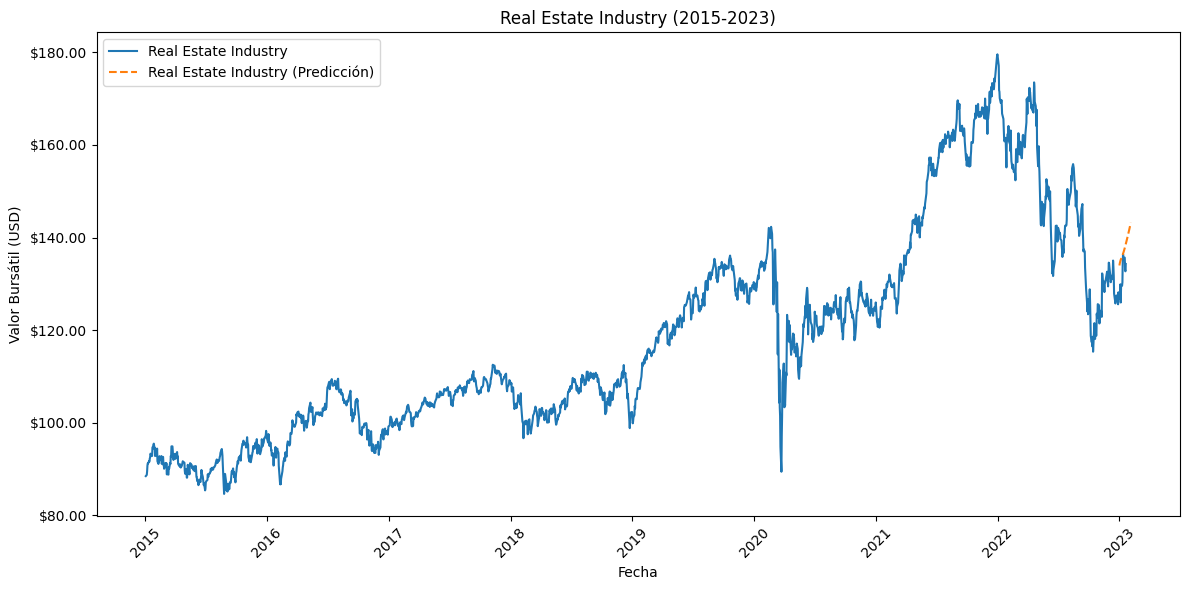

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Cargar los datos desde un archivo Excel
data = pd.read_excel('/content/Industry SP500 Mean.xlsx', parse_dates=['Date'])

# Seleccionar las columnas con los valores de las empresas
company_columns = ['Real Estate Industry' ]

# Obtener los valores de las empresas como una matriz 2D
values = data[company_columns].values

# Normalizar los datos
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_values = scaler.fit_transform(values)

# Dividir los datos en conjuntos de entrenamiento y prueba
train_size = int(len(scaled_values) * 0.8)
train_data, test_data = scaled_values[:train_size], scaled_values[train_size:]

# Crear conjuntos de datos de entrada y salida
def create_dataset(data, window_size):
    X, y = [], []
    for i in range(len(data) - window_size - 1):
        X.append(data[i:(i + window_size), :])
        y.append(data[i + window_size, :])
    return np.array(X), np.array(y)

window_size = 30  # Tamaño de la ventana para el conjunto de datos de entrada
X_train, y_train = create_dataset(train_data, window_size)
X_test, y_test = create_dataset(test_data, window_size)

# Crear el modelo de red neuronal
model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(300, activation='relu', input_shape=(window_size, len(company_columns))),
    tf.keras.layers.Dense(len(company_columns))
])

# Compilar el modelo
model.compile(optimizer='adam', loss='mean_squared_error')

# Entrenar el modelo
model.fit(X_train, y_train, epochs=60, batch_size=50)

# Realizar predicciones
train_predictions = model.predict(X_train)
test_predictions = model.predict(X_test)

# Invertir la normalización de los datos
train_predictions = scaler.inverse_transform(train_predictions)
y_train = scaler.inverse_transform(y_train)
test_predictions = scaler.inverse_transform(test_predictions)
y_test = scaler.inverse_transform(y_test)

# Calcular el error RMSE
train_rmse = np.sqrt(mean_squared_error(y_train, train_predictions))
test_rmse = np.sqrt(mean_squared_error(y_test, test_predictions))
print("RMSE (Entrenamiento):", train_rmse)
print("RMSE (Prueba):", test_rmse)

# Obtener la ventana de datos de prueba más reciente
last_window = scaled_values[-window_size:, :]

# Realizar predicción de los próximos 50 días
future_predictions = []
for _ in range(35):
    future_prediction = model.predict(last_window.reshape(1, window_size, len(company_columns)))
    future_predictions.append(future_prediction)
    last_window = np.append(last_window[1:, :], future_prediction, axis=0)

# Invertir la normalización de las predicciones futuras
future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1, len(company_columns)))

# Crear las fechas para los próximos 50 días a partir del 1 de enero de 2023
start_date = pd.to_datetime('2023-01-01')
date_range = pd.date_range(start=start_date, periods=35)

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# Graficar los resultados
plt.figure(figsize=(12, 6))
for i, company in enumerate(company_columns):
    plt.plot(data['Date'], values[:, i], label=company)
    plt.plot(date_range, future_predictions[:, i], label=f'{company} (Predicción)', linestyle='--')

# Función para formatear los valores en dólares
def dollar_format(x, pos):
    return f'${x:.2f}'

# Configurar el formateador de ejes para mostrar valores en dólares
formatter = ticker.FuncFormatter(dollar_format)
plt.gca().yaxis.set_major_formatter(formatter)

plt.xlabel('Fecha')
plt.ylabel('Valor Bursátil (USD)')
plt.title('Real Estate Industry (2015-2023)')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

##Communication Services Industry

Epoch 1/60
32/32 [==============================] - 9s 221ms/step - loss: 0.0261
Epoch 2/60
32/32 [==============================] - 8s 247ms/step - loss: 4.8440e-04
Epoch 3/60
32/32 [==============================] - 8s 256ms/step - loss: 3.8951e-04
Epoch 4/60
32/32 [==============================] - 7s 221ms/step - loss: 3.5752e-04
Epoch 5/60
32/32 [==============================] - 8s 257ms/step - loss: 3.6639e-04
Epoch 6/60
32/32 [==============================] - 7s 219ms/step - loss: 3.3287e-04
Epoch 7/60
32/32 [==============================] - 8s 256ms/step - loss: 3.5094e-04
Epoch 8/60
32/32 [==============================] - 8s 257ms/step - loss: 3.4355e-04
Epoch 9/60
32/32 [==============================] - 7s 219ms/step - loss: 3.4672e-04
Epoch 10/60
32/32 [==============================] - 8s 257ms/step - loss: 3.0893e-04
Epoch 11/60
32/32 [==============================] - 7s 219ms/step - loss: 4.5336e-04
Epoch 12/60
32/32 [==============================] - 8s 254ms/step 

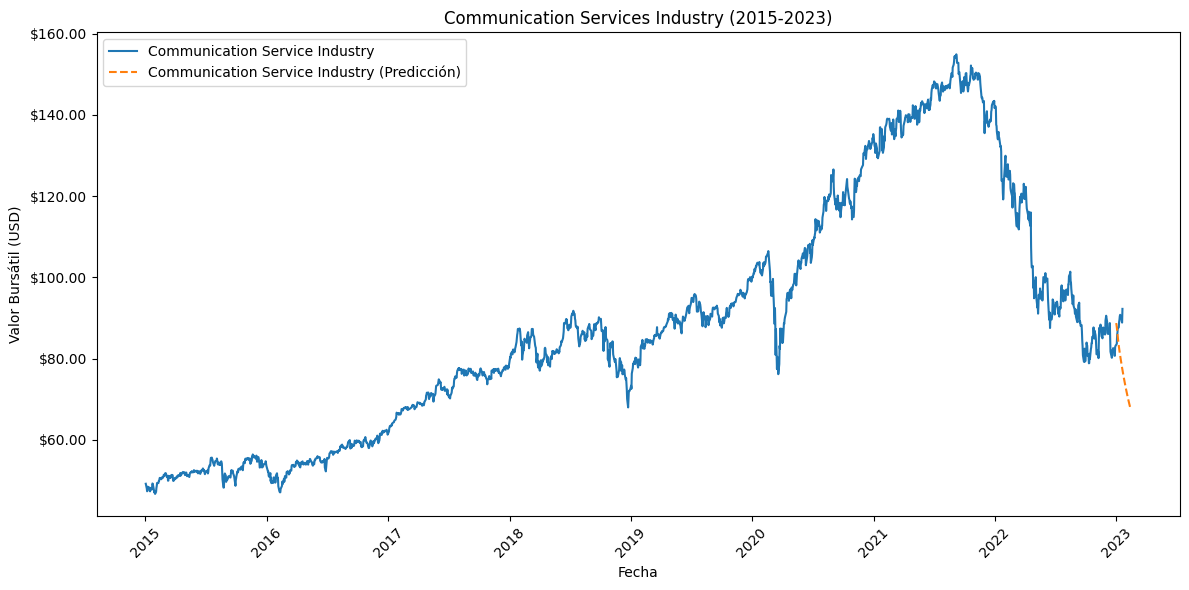

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Cargar los datos desde un archivo Excel
data = pd.read_excel('/content/Industry SP500 Mean.xlsx', parse_dates=['Date'])

# Seleccionar las columnas con los valores de las empresas
company_columns = ['Communication Service Industry' ]

# Obtener los valores de las empresas como una matriz 2D
values = data[company_columns].values

# Normalizar los datos
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_values = scaler.fit_transform(values)

# Dividir los datos en conjuntos de entrenamiento y prueba
train_size = int(len(scaled_values) * 0.8)
train_data, test_data = scaled_values[:train_size], scaled_values[train_size:]

# Crear conjuntos de datos de entrada y salida
def create_dataset(data, window_size):
    X, y = [], []
    for i in range(len(data) - window_size - 1):
        X.append(data[i:(i + window_size), :])
        y.append(data[i + window_size, :])
    return np.array(X), np.array(y)

window_size = 30  # Tamaño de la ventana para el conjunto de datos de entrada
X_train, y_train = create_dataset(train_data, window_size)
X_test, y_test = create_dataset(test_data, window_size)

# Crear el modelo de red neuronal
model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(400, activation='relu', input_shape=(window_size, len(company_columns))),
    tf.keras.layers.Dense(len(company_columns))
])

# Compilar el modelo
model.compile(optimizer='adam', loss='mean_squared_error')

# Entrenar el modelo
model.fit(X_train, y_train, epochs=60, batch_size=50)

# Realizar predicciones
train_predictions = model.predict(X_train)
test_predictions = model.predict(X_test)

# Invertir la normalización de los datos
train_predictions = scaler.inverse_transform(train_predictions)
y_train = scaler.inverse_transform(y_train)
test_predictions = scaler.inverse_transform(test_predictions)
y_test = scaler.inverse_transform(y_test)

# Calcular el error RMSE
train_rmse = np.sqrt(mean_squared_error(y_train, train_predictions))
test_rmse = np.sqrt(mean_squared_error(y_test, test_predictions))
print("RMSE (Entrenamiento):", train_rmse)
print("RMSE (Prueba):", test_rmse)

# Obtener la ventana de datos de prueba más reciente
last_window = scaled_values[-window_size:, :]

# Realizar predicción de los próximos 50 días
future_predictions = []
for _ in range(45):
    future_prediction = model.predict(last_window.reshape(1, window_size, len(company_columns)))
    future_predictions.append(future_prediction)
    last_window = np.append(last_window[1:, :], future_prediction, axis=0)

# Invertir la normalización de las predicciones futuras
future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1, len(company_columns)))

# Crear las fechas para los próximos 50 días a partir del 1 de enero de 2023
start_date = pd.to_datetime('2023-01-01')
date_range = pd.date_range(start=start_date, periods=45)

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# Graficar los resultados
plt.figure(figsize=(12, 6))
for i, company in enumerate(company_columns):
    plt.plot(data['Date'], values[:, i], label=company)
    plt.plot(date_range, future_predictions[:, i], label=f'{company} (Predicción)', linestyle='--')

# Función para formatear los valores en dólares
def dollar_format(x, pos):
    return f'${x:.2f}'

# Configurar el formateador de ejes para mostrar valores en dólares
formatter = ticker.FuncFormatter(dollar_format)
plt.gca().yaxis.set_major_formatter(formatter)

plt.xlabel('Fecha')
plt.ylabel('Valor Bursátil (USD)')
plt.title('Communication Services Industry (2015-2023)')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

##Utilities Industry

Epoch 1/60
32/32 [==============================] - 11s 295ms/step - loss: 0.0357
Epoch 2/60
32/32 [==============================] - 9s 295ms/step - loss: 0.0018
Epoch 3/60
32/32 [==============================] - 9s 267ms/step - loss: 0.0015
Epoch 4/60
32/32 [==============================] - 9s 287ms/step - loss: 0.0011
Epoch 5/60
32/32 [==============================] - 9s 292ms/step - loss: 0.0014
Epoch 6/60
32/32 [==============================] - 9s 293ms/step - loss: 0.0011
Epoch 7/60
32/32 [==============================] - 9s 289ms/step - loss: 0.0010
Epoch 8/60
32/32 [==============================] - 9s 268ms/step - loss: 0.0011
Epoch 9/60
32/32 [==============================] - 9s 294ms/step - loss: 0.0011
Epoch 10/60
32/32 [==============================] - 9s 292ms/step - loss: 9.3416e-04
Epoch 11/60
32/32 [==============================] - 9s 293ms/step - loss: 9.3268e-04
Epoch 12/60
32/32 [==============================] - 9s 270ms/step - loss: 9.1771e-04
Epoch 13/60


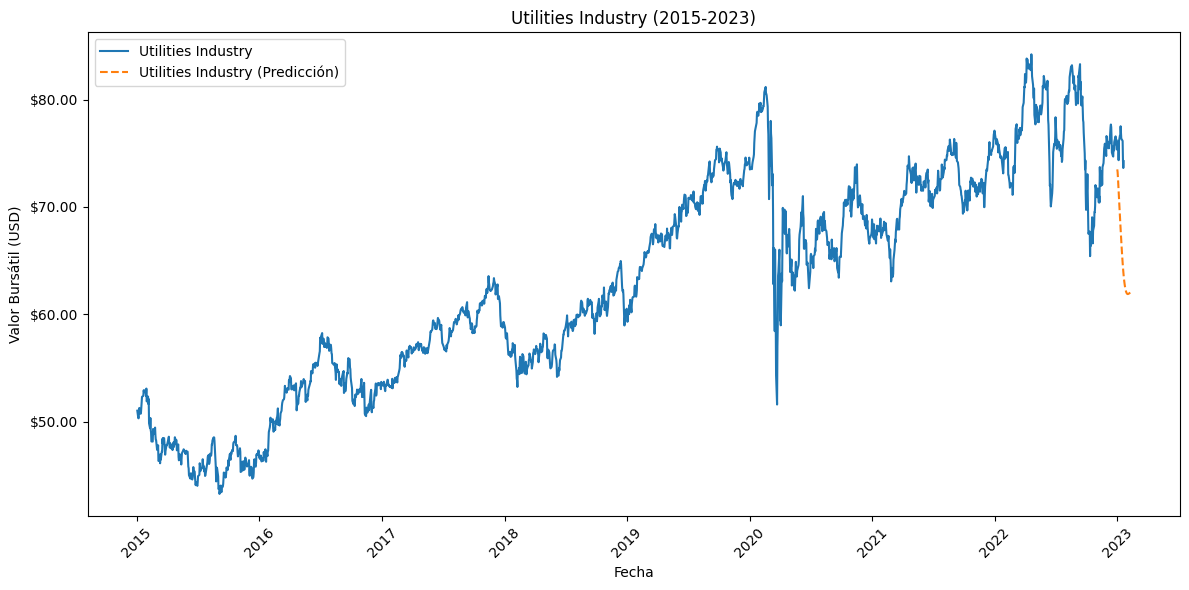

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Cargar los datos desde un archivo Excel
data = pd.read_excel('/content/Industry SP500 Mean.xlsx', parse_dates=['Date'])

# Seleccionar las columnas con los valores de las empresas
company_columns = ['Utilities Industry' ]

# Obtener los valores de las empresas como una matriz 2D
values = data[company_columns].values

# Normalizar los datos
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_values = scaler.fit_transform(values)

# Dividir los datos en conjuntos de entrenamiento y prueba
train_size = int(len(scaled_values) * 0.8)
train_data, test_data = scaled_values[:train_size], scaled_values[train_size:]

# Crear conjuntos de datos de entrada y salida
def create_dataset(data, window_size):
    X, y = [], []
    for i in range(len(data) - window_size - 1):
        X.append(data[i:(i + window_size), :])
        y.append(data[i + window_size, :])
    return np.array(X), np.array(y)

window_size = 30  # Tamaño de la ventana para el conjunto de datos de entrada
X_train, y_train = create_dataset(train_data, window_size)
X_test, y_test = create_dataset(test_data, window_size)

# Crear el modelo de red neuronal
model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(450, activation='relu', input_shape=(window_size, len(company_columns))),
    tf.keras.layers.Dense(len(company_columns))
])

# Compilar el modelo
model.compile(optimizer='adam', loss='mean_squared_error')

# Entrenar el modelo
model.fit(X_train, y_train, epochs=60, batch_size=50)

# Realizar predicciones
train_predictions = model.predict(X_train)
test_predictions = model.predict(X_test)

# Invertir la normalización de los datos
train_predictions = scaler.inverse_transform(train_predictions)
y_train = scaler.inverse_transform(y_train)
test_predictions = scaler.inverse_transform(test_predictions)
y_test = scaler.inverse_transform(y_test)

# Calcular el error RMSE
train_rmse = np.sqrt(mean_squared_error(y_train, train_predictions))
test_rmse = np.sqrt(mean_squared_error(y_test, test_predictions))
print("RMSE (Entrenamiento):", train_rmse)
print("RMSE (Prueba):", test_rmse)

# Obtener la ventana de datos de prueba más reciente
last_window = scaled_values[-window_size:, :]

# Realizar predicción de los próximos 50 días
future_predictions = []
for _ in range(40):
    future_prediction = model.predict(last_window.reshape(1, window_size, len(company_columns)))
    future_predictions.append(future_prediction)
    last_window = np.append(last_window[1:, :], future_prediction, axis=0)

# Invertir la normalización de las predicciones futuras
future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1, len(company_columns)))

# Crear las fechas para los próximos 50 días a partir del 1 de enero de 2023
start_date = pd.to_datetime('2023-01-01')
date_range = pd.date_range(start=start_date, periods=40)

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# Graficar los resultados
plt.figure(figsize=(12, 6))
for i, company in enumerate(company_columns):
    plt.plot(data['Date'], values[:, i], label=company)
    plt.plot(date_range, future_predictions[:, i], label=f'{company} (Predicción)', linestyle='--')

# Función para formatear los valores en dólares
def dollar_format(x, pos):
    return f'${x:.2f}'

# Configurar el formateador de ejes para mostrar valores en dólares
formatter = ticker.FuncFormatter(dollar_format)
plt.gca().yaxis.set_major_formatter(formatter)

plt.xlabel('Fecha')
plt.ylabel('Valor Bursátil (USD)')
plt.title('Utilities Industry (2015-2023)')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

##Financials Industry

Epoch 1/60
32/32 [==============================] - 9s 222ms/step - loss: 0.0178
Epoch 2/60
32/32 [==============================] - 8s 243ms/step - loss: 6.9794e-04
Epoch 3/60
32/32 [==============================] - 7s 220ms/step - loss: 4.9762e-04
Epoch 4/60
32/32 [==============================] - 8s 248ms/step - loss: 5.1657e-04
Epoch 5/60
32/32 [==============================] - 8s 245ms/step - loss: 6.5335e-04
Epoch 6/60
32/32 [==============================] - 7s 223ms/step - loss: 4.7865e-04
Epoch 7/60
32/32 [==============================] - 8s 250ms/step - loss: 4.0214e-04
Epoch 8/60
32/32 [==============================] - 8s 258ms/step - loss: 4.0371e-04
Epoch 9/60
32/32 [==============================] - 7s 224ms/step - loss: 3.8932e-04
Epoch 10/60
32/32 [==============================] - 8s 247ms/step - loss: 3.5195e-04
Epoch 11/60
32/32 [==============================] - 8s 241ms/step - loss: 3.7968e-04
Epoch 12/60
32/32 [==============================] - 7s 222ms/step 

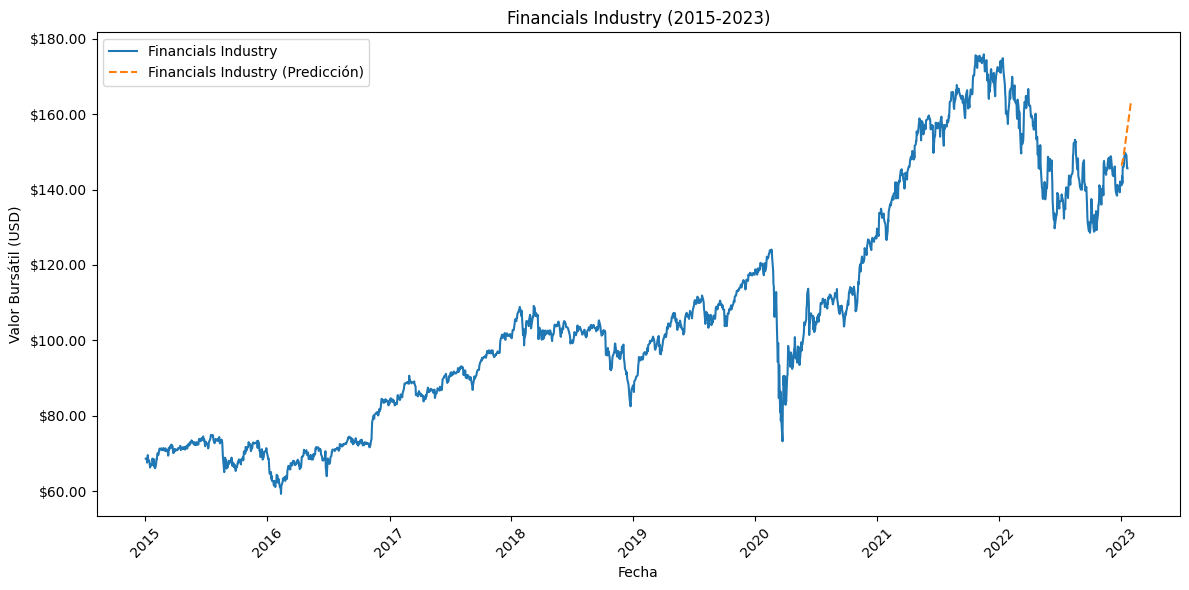

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Cargar los datos desde un archivo Excel
data = pd.read_excel('/content/Industry SP500 Mean.xlsx', parse_dates=['Date'])

# Seleccionar las columnas con los valores de las empresas
company_columns = ['Financials Industry' ]

# Obtener los valores de las empresas como una matriz 2D
values = data[company_columns].values

# Normalizar los datos
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_values = scaler.fit_transform(values)

# Dividir los datos en conjuntos de entrenamiento y prueba
train_size = int(len(scaled_values) * 0.8)
train_data, test_data = scaled_values[:train_size], scaled_values[train_size:]

# Crear conjuntos de datos de entrada y salida
def create_dataset(data, window_size):
    X, y = [], []
    for i in range(len(data) - window_size - 1):
        X.append(data[i:(i + window_size), :])
        y.append(data[i + window_size, :])
    return np.array(X), np.array(y)

window_size = 30  # Tamaño de la ventana para el conjunto de datos de entrada
X_train, y_train = create_dataset(train_data, window_size)
X_test, y_test = create_dataset(test_data, window_size)

# Crear el modelo de red neuronal
model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(400, activation='relu', input_shape=(window_size, len(company_columns))),
    tf.keras.layers.Dense(len(company_columns))
])

# Compilar el modelo
model.compile(optimizer='adam', loss='mean_squared_error')

# Entrenar el modelo
model.fit(X_train, y_train, epochs=60, batch_size=50)

# Realizar predicciones
train_predictions = model.predict(X_train)
test_predictions = model.predict(X_test)

# Invertir la normalización de los datos
train_predictions = scaler.inverse_transform(train_predictions)
y_train = scaler.inverse_transform(y_train)
test_predictions = scaler.inverse_transform(test_predictions)
y_test = scaler.inverse_transform(y_test)

# Calcular el error RMSE
train_rmse = np.sqrt(mean_squared_error(y_train, train_predictions))
test_rmse = np.sqrt(mean_squared_error(y_test, test_predictions))
print("RMSE (Entrenamiento):", train_rmse)
print("RMSE (Prueba):", test_rmse)

# Obtener la ventana de datos de prueba más reciente
last_window = scaled_values[-window_size:, :]

# Realizar predicción de los próximos 50 días
future_predictions = []
for _ in range(30):
    future_prediction = model.predict(last_window.reshape(1, window_size, len(company_columns)))
    future_predictions.append(future_prediction)
    last_window = np.append(last_window[1:, :], future_prediction, axis=0)

# Invertir la normalización de las predicciones futuras
future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1, len(company_columns)))

# Crear las fechas para los próximos 50 días a partir del 1 de enero de 2023
start_date = pd.to_datetime('2023-01-01')
date_range = pd.date_range(start=start_date, periods=30)

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# Graficar los resultados
plt.figure(figsize=(12, 6))
for i, company in enumerate(company_columns):
    plt.plot(data['Date'], values[:, i], label=company)
    plt.plot(date_range, future_predictions[:, i], label=f'{company} (Predicción)', linestyle='--')

# Función para formatear los valores en dólares
def dollar_format(x, pos):
    return f'${x:.2f}'

# Configurar el formateador de ejes para mostrar valores en dólares
formatter = ticker.FuncFormatter(dollar_format)
plt.gca().yaxis.set_major_formatter(formatter)

plt.xlabel('Fecha')
plt.ylabel('Valor Bursátil (USD)')
plt.title('Financials Industry (2015-2023)')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

##Energy Industry

Epoch 1/60
32/32 [==============================] - 6s 140ms/step - loss: 0.0366
Epoch 2/60
32/32 [==============================] - 5s 164ms/step - loss: 0.0015
Epoch 3/60
32/32 [==============================] - 6s 176ms/step - loss: 0.0010
Epoch 4/60
32/32 [==============================] - 5s 162ms/step - loss: 0.0010
Epoch 5/60
32/32 [==============================] - 5s 162ms/step - loss: 8.2307e-04
Epoch 6/60
32/32 [==============================] - 5s 143ms/step - loss: 8.3444e-04
Epoch 7/60
32/32 [==============================] - 5s 164ms/step - loss: 8.0855e-04
Epoch 8/60
32/32 [==============================] - 4s 139ms/step - loss: 7.1625e-04
Epoch 9/60
32/32 [==============================] - 5s 142ms/step - loss: 6.9066e-04
Epoch 10/60
32/32 [==============================] - 5s 167ms/step - loss: 6.9210e-04
Epoch 11/60
32/32 [==============================] - 4s 139ms/step - loss: 5.9150e-04
Epoch 12/60
32/32 [==============================] - 5s 160ms/step - loss: 5.40

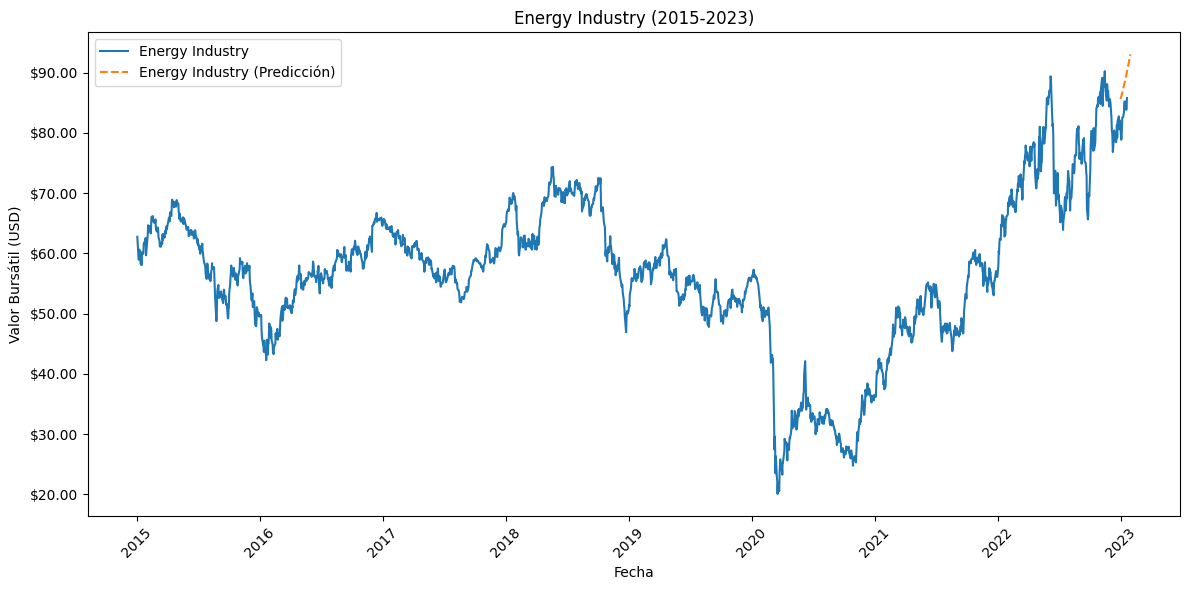

In [70]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Cargar los datos desde un archivo Excel
data = pd.read_excel('/content/Industry SP500 Mean.xlsx', parse_dates=['Date'])

# Seleccionar las columnas con los valores de las empresas
company_columns = ['Energy Industry' ]

# Obtener los valores de las empresas como una matriz 2D
values = data[company_columns].values

# Normalizar los datos
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_values = scaler.fit_transform(values)

# Dividir los datos en conjuntos de entrenamiento y prueba
train_size = int(len(scaled_values) * 0.8)
train_data, test_data = scaled_values[:train_size], scaled_values[train_size:]

# Crear conjuntos de datos de entrada y salida
def create_dataset(data, window_size):
    X, y = [], []
    for i in range(len(data) - window_size - 1):
        X.append(data[i:(i + window_size), :])
        y.append(data[i + window_size, :])
    return np.array(X), np.array(y)

window_size = 30  # Tamaño de la ventana para el conjunto de datos de entrada
X_train, y_train = create_dataset(train_data, window_size)
X_test, y_test = create_dataset(test_data, window_size)

# Crear el modelo de red neuronal
model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(300, activation='relu', input_shape=(window_size, len(company_columns))),
    tf.keras.layers.Dense(len(company_columns))
])

# Compilar el modelo
model.compile(optimizer='adam', loss='mean_squared_error')

# Entrenar el modelo
model.fit(X_train, y_train, epochs=60, batch_size=50)

# Realizar predicciones
train_predictions = model.predict(X_train)
test_predictions = model.predict(X_test)

# Invertir la normalización de los datos
train_predictions = scaler.inverse_transform(train_predictions)
y_train = scaler.inverse_transform(y_train)
test_predictions = scaler.inverse_transform(test_predictions)
y_test = scaler.inverse_transform(y_test)

# Calcular el error RMSE
train_rmse = np.sqrt(mean_squared_error(y_train, train_predictions))
test_rmse = np.sqrt(mean_squared_error(y_test, test_predictions))
print("RMSE (Entrenamiento):", train_rmse)
print("RMSE (Prueba):", test_rmse)

# Obtener la ventana de datos de prueba más reciente
last_window = scaled_values[-window_size:, :]

# Realizar predicción de los próximos 50 días
future_predictions = []
for _ in range(30):
    future_prediction = model.predict(last_window.reshape(1, window_size, len(company_columns)))
    future_predictions.append(future_prediction)
    last_window = np.append(last_window[1:, :], future_prediction, axis=0)

# Invertir la normalización de las predicciones futuras
future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1, len(company_columns)))

# Crear las fechas para los próximos 50 días a partir del 1 de enero de 2023
start_date = pd.to_datetime('2023-01-01')
date_range = pd.date_range(start=start_date, periods=30)

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# Graficar los resultados
plt.figure(figsize=(12, 6))
for i, company in enumerate(company_columns):
    plt.plot(data['Date'], values[:, i], label=company)
    plt.plot(date_range, future_predictions[:, i], label=f'{company} (Predicción)', linestyle='--')

# Función para formatear los valores en dólares
def dollar_format(x, pos):
    return f'${x:.2f}'

# Configurar el formateador de ejes para mostrar valores en dólares
formatter = ticker.FuncFormatter(dollar_format)
plt.gca().yaxis.set_major_formatter(formatter)

plt.xlabel('Fecha')
plt.ylabel('Valor Bursátil (USD)')
plt.title('Energy Industry (2015-2023)')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()